In [1]:
import numpy as np
import pandas as pd
from BS_pricer import *
from Parameters import *
from Processes import *
import scipy.stats as ss
from scipy.integrate import quad
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
S0 = 100.0  # spot stock price
K = 100.0  # strike
T = 1.0  # maturity
r = 0.1  # risk free rate
sig = 0.2  # diffusion coefficient or volatility

In [3]:
call = BS_pricer.BS_closed("call", S0, K, T, r, sig)
put = BS_pricer.BS_closed("put", S0, K, T, r, sig)
print("Call price: ", call)
print("Put price: ", put)

Call price:  13.269676584660893
Put price:  3.753418388256833


In [6]:
print(call)
print(put + S0 - K*np.exp(-r*T))
#put call parity

13.269676584660893
13.269676584660886


Computing Option prices using Integration

In [11]:
exp_ret = np.log(S0) + (r-0.5*sig**2)
vol  = sig*np.sqrt(T)

def log_normal(x,exp_ret,vol):
    return (1/((np.sqrt(2*np.pi)*x*vol)))*np.exp(-(np.log(x) - exp_ret)**2/(2*vol**2))
            

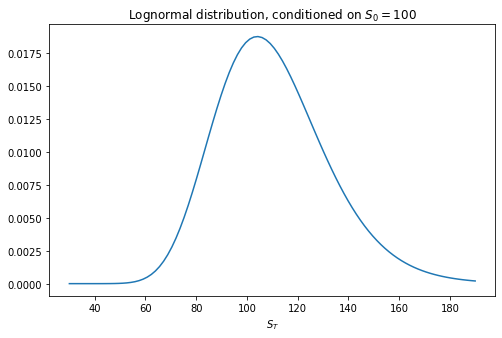

In [12]:
plt.figure(figsize=(8, 5))
x = np.linspace(30, 190, 100)
plt.plot(x, log_normal(x, exp_ret, vol))
plt.title("Lognormal distribution, conditioned on $S_0=100$")
plt.xlabel("$S_T$")
plt.show()

In [14]:
def integrand(S,strike , exp_Ret,vol,payoff):
    if payoff == "call":
        return (S-strike)*ss.lognorm.pdf(S,vol , scale = np.exp(exp_ret))
    elif payoff == "put":
        return (strike-S)*ss.lognorm.pdf(S,vol , scale = np.exp(exp_ret))

call = quad(integrand, K, np.inf, args=(K, exp_ret, vol, "call"))[0] * np.exp(-r * T)
put = quad(integrand, 0, K, args=(K, exp_ret, vol, "put"))[0] * np.exp(-r * T)

print("Call price: {} \nPut price: {} ".format(call, put))

Call price: 13.269676584660926 
Put price: 3.753418388256828 


In [3]:
opt_param = Option_param(S0=100,K=100,T=1,exercise = "European" ,payoff = "call")
diffusion_param = Diffusion_process(r=0.1,sig = 0.2)
BS = BS_pricer(opt_param , diffusion_param)

In [4]:
BS.BS_MC(N=30000000, Err=True, Time=True)
# output is: price, standard error and execution time

(array([13.27324864]), array([0.00294153]), 1.8759264945983887)

Binomial Tree

In [47]:
N= 2000
payoff = "call"
dt = float(T)/N
u = np.exp(sig*np.sqrt(dt))
d = 1.0/u

V = np.zeros(N+1)

S_T = np.array([S0*u**(N-j)*d**j for j in range(N+1)])

a = np.exp(r*dt)
p = (a-d)/(u-d)
q = 1.0-p

V[:] = np.maximum(S_T-K,0.0)

for i in range(N,1,-1):
    #print(i)
    for j in range(i):
       V[j] = np.exp(-r*dt)*(V[j]*p + V[j+1]*q)

print("Binomial tree price: " , V[0])

Binomial tree price:  13.590948666100267


Limitations

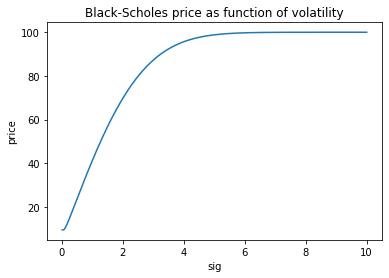

In [49]:
BS_sigma = partial(BS_pricer.BS_closed, "call", S0, K, T, r)  # binding the function
sigmas = np.linspace(0.01, 10, 1000)

plt.plot(sigmas, BS_sigma(sigmas))
plt.xlabel("sig")
plt.ylabel("price")
plt.title("Black-Scholes price as function of volatility")
plt.show()
